# Fitting a Hologram

This notebook shows how to load a pre-recorded hologram of a colloidal sphere
into a Feature object and analyze it with Lorenz-Mie theory. The analysis yields
the radius of the sphere, the refractive index of the sphere, and the sphere's
three-dimensional location relative to the center of the imaging plane.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2

from pylorenzmie.analysis import Frame

## Framework for Lorenz-Mie analysis
First, we instantiate a Frame() object. By default, Frame analyzes features with 
the standard Lorenz-Mie model for hologram formation. The model includes a description of the holographic microscope that records the images we wish to analyze. In this example, we specify that the instrument illuminates the sample with blue light at a vacuum wavelength of $\lambda$ = 0.447 μm and has a system magnification of 0.048 μm/pixel. For particles dispersed in water, the refractive index of the medium is $n_m$ = 1.340 at the imaging wavelength. These calibration constants may differ for different hardware implementations.
The commercial xSight instrument, for example, uses a system magnification of 0.120 μm/pixel.

In [2]:
configuration = dict(wavelength = 0.447,    # [um]
                     magnification = 0.048, # [um/pixel]
                     n_m = 1.34, 
                     distribution = 'radial',
                     percentpix = 0.2)

frame = Frame(**configuration)

## Read in holographic microscopy data
Next, we load the (normalized) hologram we wish to fit. In the present example, we use OpenCV to load a pre-recorded hologram that was saved as a PNG image. We convert the image to grayscale and normalize it by the mean value. This hologram was cropped from a larger image. Since we are not interested in locating the particle within the original image, we provide the model with a standard coordinate system using the coordinates() helper function. We finally can provide the normalized image data to the Feature() object for analysis.

In [3]:
# Read example image
image = cv2.imread('tutorials/image0010.png', 0).astype(float)

## Holograms must be normalized for analysis

In [4]:
image /= np.mean(image)

## Identify features and estimate bounding boxes

In [5]:
# Features identified by eye
x_p = np.array([563, 920])
y_p = np.array([720, 732])

# Bounding boxes
w, h = 400, 400
x0 = (x_p - w/2).astype(int)
y0 = (y_p - h/2).astype(int)
bboxes = [((x0[n], y0[n]), w, h) for n in range(2)]

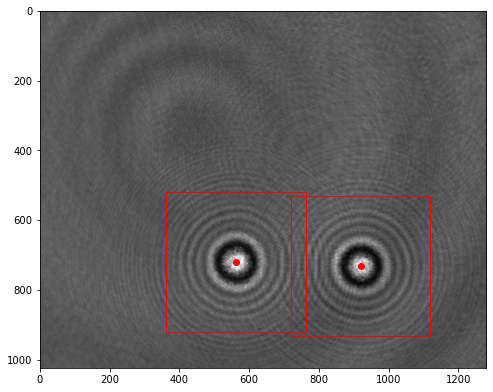

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image, cmap='gray')
ax.scatter(x_p, y_p, color='r')
for bbox in bboxes:
    ax.add_patch(Rectangle(*bbox, fill=False, ec='r'))

## Load image data and bounding boxes into frame

In [7]:
frame.data = image
frame.bboxes = bboxes

## Estimate the parameters for each particle and perform fits

In [8]:
for n, feature in enumerate(frame.features):
    particle = feature.particle
    particle.r_p = np.array([x_p[n], y_p[n], 200])
    particle.n_p = 1.5
    particle.a_p = 1.

results = frame.optimize()

In [9]:
print(results)

          x_p      dx_p         y_p      dy_p         z_p      dz_p       a_p  \
0  562.321820  0.053319  720.326608  0.051445  174.331964  0.226904  2.096269   
1  920.199627  0.054777  732.418653  0.051095  172.978726  0.228122  2.052543   

       da_p       n_p      dn_p  success   npix    redchi  
0  0.002136  1.370219  0.000108     True  32000  9.942433  
1  0.002129  1.369896  0.000108     True  32000  9.468673  
